## Discretization

Discretization is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that span the range of the variable's values. Discretization is also called **binning**, where bin is an alternative name for interval.


### Discretization helps handle outliers and may improve the value spread in skewed variables

Discretization helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval or bucket. In addition, by creating appropriate bins or intervals, discretization can help spread the values of a skewed variable across a set of bins with an equal number of observations.


### Discretization approaches

There are several approaches to transform continuous variables into discrete ones. Discretization methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information other than the variable distribution to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.


####  Unsupervised discretization methods

- Equal width discretisation
- Equal frequency discretization
- K-means discretization

#### Supervised discretization methods

- Discretization using decision trees


## Equal width discretization

Equal width discretization divides the scope of possible values into N bins of the same width. The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

width = (max value - min value) / N

where N is the number of bins or intervals.

For example, if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N; that is something to determine experimentally.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [22]:
# load the numerical variables of the Titanic Dataset
data = pd.read_csv('../../Data/titanic.csv', usecols=['age', 'fare', 'survived'])

data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [23]:
# Let's separate into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and fare contain missing data, which I will fill by extracting a random sample of the variable.

In [24]:
def impute_na(data, variable):
    df = data.copy()

    # random sampling
    df[variable + '_random'] = df[variable]

    # extract the random sample to fill the na
    random_sample = df[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)

    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable + '_random'] = random_sample

    return df[variable + '_random']

In [25]:
# replace NA in both train and test sets
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

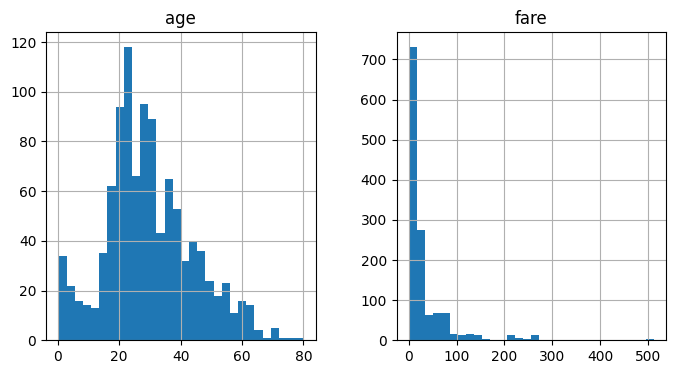

In [26]:
# let's explore the distribution of age
data[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal width discretisation with pandas

In [27]:
# let's make labels to label the different bins
labels = ['bin_' + str(i) for i in range(1, 9)]
labels

['bin_1', 'bin_2', 'bin_3', 'bin_4', 'bin_5', 'bin_6', 'bin_7', 'bin_8']

In [28]:
# create binned age / discretise age
# create one column with labels
X_train['Age_disc_labels'], bins = pd.cut(
    x=X_train['age'], bins=8, labels=labels, retbins=True, precision=0, include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(
    x=X_train['age'], bins=bins, precision=0, include_lowest=True)

X_train.head(10)

,age,fare,Age_disc_labels,Age_disc
501,13.0,19.5000,bin_2,"(9.0, 19.0]"
588,4.0,23.0000,bin_1,"(-0.9, 9.0]"
402,30.0,13.8583,bin_4,"(28.0, 37.0]"
1193,40.5,7.7250,bin_5,"(37.0, 46.0]"
686,22.0,7.7250,bin_3,"(19.0, 28.0]"
971,39.0,7.8792,bin_5,"(37.0, 46.0]"
117,30.0,56.9292,bin_4,"(28.0, 37.0]"
540,2.0,26.0000,bin_1,"(-0.9, 9.0]"
294,49.0,110.8833,bin_6,"(46.0, 56.0]"
261,35.0,26.2875,bin_4,"(28.0, 37.0]"


In [30]:
# the limits of the intervals
bins

array([ 0.0928667,  9.3958625, 18.625025 , 27.8541875, 37.08335  ,
       46.3125125, 55.541675 , 64.7708375, 74.       ])

We can see in the above output how by discretising using equal width, we placed each Age observation within one interval / bin. For example, age=13 was placed in the 9-19 interval, whereas age 30 was placed into the 28-37 interval.

When performing equal width discretisation, we guarantee that the intervals are all of the same length, however there won't necessarily be the same number of observations in each of the intervals. See below:

In [10]:
# number of observations per interval
X_train.groupby('Age_disc')['age'].count()

Age_disc
(-0.9, 9.0]      64
(9.0, 19.0]      90
(19.0, 28.0]    277
(28.0, 37.0]    243
(37.0, 46.0]    114
(46.0, 56.0]     77
(56.0, 65.0]     40
(65.0, 74.0]     11
Name: age, dtype: int64

Text(0, 0.5, 'Number of observations per bin')

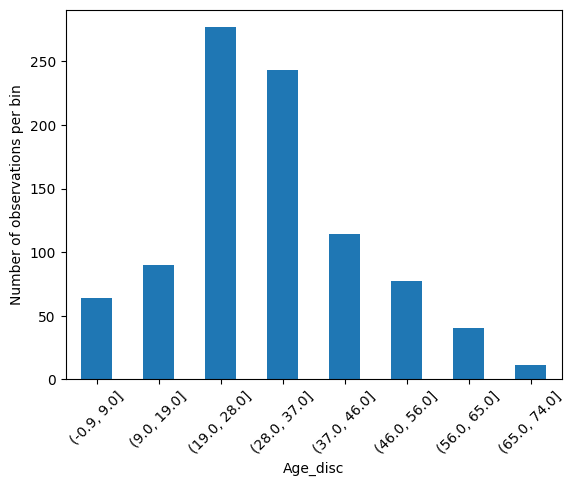

In [11]:
X_train.groupby('Age_disc')['age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

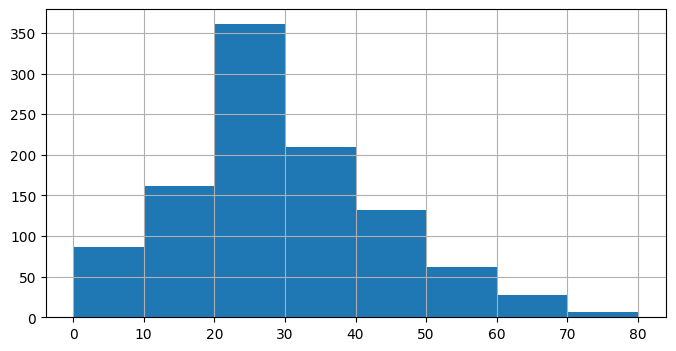

In [12]:
# let's explore the distribution of age
data['age'].hist(bins=8, figsize=(8,4))
plt.show()

The majority of people on the Titanic were between 18-36 years of age.

Now, we can discretise Age in the test set, using the **same interval boundaries** that we calculated for the train set:

In [12]:
# discretize the test set
# note that we use the bin limits learned from the train set
X_test['Age_disc_labels'] = pd.cut(
    x=X_test['age'], bins=bins, labels=labels, precision=0, include_lowest=True)

X_test['Age_disc'] = pd.cut(x=X_test['age'], bins=bins, precision=0, include_lowest=True)

X_test.head()

,age,fare,Age_disc_labels,Age_disc
1139,38.0,7.8958,bin_5,"(37.0, 46.0]"
533,21.0,21.0000,bin_3,"(19.0, 28.0]"
459,42.0,27.0000,bin_5,"(37.0, 46.0]"
1150,3.0,14.5000,bin_1,"(-0.9, 9.0]"
393,25.0,31.5000,bin_3,"(19.0, 28.0]"


Text(0, 0.5, 'Number of observations per bin')

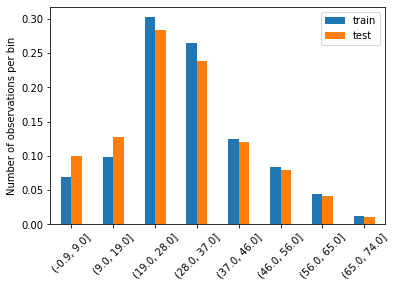

In [13]:
# if the distributions in train and test set are similar, we should expect similar propotion of
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train['Age_disc'].value_counts(normalize=True).sort_index()
t2 = X_test['Age_disc'].value_counts(normalize=True).sort_index()

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')